In [1]:
# Required libraries
import os
import math
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [2]:
# Constants
my_data = "../data"

## Import data

Set of legacy questions to train/test the model. Query loads questions where last modification date was last year.

Stackexchange query is https://data.stackexchange.com/stackoverflow/query/edit/847084

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2017-04-01') 
and (LastActivityDate < '2018-04-01') and (PostTypeId = 1)

In [3]:
# Load data into Pandas dataframe
datafile = "QueryResultsOld.csv"
full_path = os.path.join(my_data, datafile)
df_questions = pd.read_csv(full_path)
print(df_questions.shape)

(15089, 8)


Other set of questions to use with the trained model

https://data.stackexchange.com/stackoverflow/query/edit/846505

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2018-04-01') and (PostTypeId = 1)

In [4]:
# Load data into Pandas dataframe
datafile = "QueryResultsNew.csv"
full_path = os.path.join(my_data, datafile)
df_new_questions = pd.read_csv(full_path)
print(df_new_questions.shape)

(3865, 8)


### Tokenize words

This piece of code cleans up the HTML content, removes stop words and converts the remaining ones into a list of stems.
The result is a new column in the table with that list for each question.

In [5]:
from nltk.stem import SnowballStemmer

# Take only aplanumeric words, no punctuation signs
tokenizer = nltk.RegexpTokenizer('\w+')

# Prepare set of stopwords
stopWords = set(stopwords.words('english'))

# Define stemmer
snowball_stemmer = SnowballStemmer("english")

wordsFiltered = []
wordsArray = []

for html_text in df_questions['body'] + " " + df_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if w not in stopWords:
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    wordsArray.append(his_words)


In [6]:
# Add a column to the dataframe with le list of cleaned stems
df_questions['words'] = wordsArray

The variabe wordsFiltered is a list with all the stems as they appear. It has duplicate entries.

In [7]:
print("Total number of stems {0}".format(len(wordsFiltered)))

words_freq = nltk.FreqDist(wordsFiltered)

print("Total number of unique stems {0}".format(len(words_freq)))

Total number of stems 975465
Total number of unique stems 40992


### Vectorize stems

The set of stems gets vectorized. Each question is a line of the matrix and each stem is a column. The values are the number of occurrences of each stem in each question.
Any word that is used in more than 95% of the questions or less than 5 times across all questions is removed, because its either too common or too specific to be used for the topic determination.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
stem_vectorizer = CountVectorizer(lowercase = True, ngram_range=(1, 2), max_df=0.95, min_df=5)
stem_matrix = stem_vectorizer.fit_transform(df_questions['words'])

### Vectorize tags

In [9]:
tag_vectorizer = CountVectorizer(lowercase = True, max_df=1.0, min_df=0, token_pattern = '[^<>]+')
tag_matrix = tag_vectorizer.fit_transform(df_questions['tags'])
print(tag_matrix.shape)

(15089, 5443)


In [10]:
# Create a datraframe with the list of tags and the number of times they are used
tag_names = tag_vectorizer.get_feature_names()

tag_df = pd.DataFrame(tag_matrix.sum(0)).T
tag_df.rename(index=str, columns={0:'number'}, inplace=True)
tag_df['names'] = tag_names

In [11]:
tf_feature_names = stem_vectorizer.get_feature_names()

## Classify new questions

The new questions get vectorized with the same set of stems than the training set. If new terms/stems are included, they are just ignored.

In [12]:
newWordsFiltered = []
newWordsArray = []

for html_text in df_new_questions['body'] + " " + df_new_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if (w not in stopWords):
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    newWordsArray.append(his_words)

# Add a column to the dataframe with le list of cleaned stems
df_new_questions['stems'] = newWordsArray
stem_matrix_new = stem_vectorizer.transform(df_new_questions['stems'])

In [13]:
# Create matrix of tags for new questions
tag_matrix_new = tag_vectorizer.fit_transform(df_new_questions['tags'])
print(tag_matrix_new.shape)

# Add tags to new questions
tag_df_new_questions = pd.DataFrame(tag_matrix_new.sum(0)).T
tag_df_new_questions.rename(index=str, columns={0:'number'}, inplace=True)
tag_names_new = tag_vectorizer.get_feature_names()
tag_df_new_questions['names'] = tag_names_new

(3865, 2616)


In [18]:
from sklearn.decomposition import LatentDirichletAllocation
score_topic = [None, None]
mean_topic = [None, None]
for no_topics in np.arange(2, 50+1, 1):

    print("{0} topics".format(no_topics))
    # Run LDA
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online',
                                    learning_offset=50.,random_state=0)

    lda_corpus = lda.fit_transform(stem_matrix)
    
    # Calculate the weight of each tag for each topic
    topic_tag_weight = np.matmul(lda_corpus.T, tag_matrix.todense())
    
    # Normalize the weight matrix to reduce the influence of the tags most used
    # topic_tag_weight_norm = topic_tag_weight / (topic_tag_weight.sum(axis = 1))
    topic_tag_weight_norm = topic_tag_weight

    # Transform new questions according to trained LDA
    lda_new_corpus = lda.transform(stem_matrix_new)

    # Calculate matrix of tags probability per new question
    new_questions_tags = lda_new_corpus.dot(topic_tag_weight_norm)
    new_questions_df = pd.DataFrame(new_questions_tags)

    # Add the list of prosed tags and the score per question to the dataframe
    for question in np.arange(0, len(df_new_questions)):
        tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
        proposed_tags = ''
        right_tags = 0
        for i in new_questions_df.iloc[question].argsort()[:-5-1:-1]:
            proposed_tag = tag_df.iloc[i]['names']
            proposed_tags += (proposed_tag) + " "
            if proposed_tag in tag_array:
                right_tags += 1
        df_new_questions.loc[question,'right'] = (right_tags/len(tag_array))
        df_new_questions.loc[question,'proposed_tags'] = proposed_tags

    # Calculate the number of questions for which at least 50% of the tags were proposed
    unsupervised_score = df_new_questions[df_new_questions['right'] >= 0.5]['Id'].count() / len(df_new_questions)
    unsupervised_mean = df_new_questions['right'].mean()
    score_topic.append(unsupervised_score)
    mean_topic.append(unsupervised_mean)
    
    print("Unsupervised methodology overall score {0}. Mean score {1}".format(unsupervised_score, unsupervised_mean))

2 topics
Unsupervised methodology overall score 0.17283311772315654. Mean score 0.19989219491160187
3 topics
Unsupervised methodology overall score 0.22354463130659766. Mean score 0.2392410521776657
4 topics
Unsupervised methodology overall score 0.2111254851228978. Mean score 0.23797326433807997
5 topics
Unsupervised methodology overall score 0.20879689521345407. Mean score 0.233113410953
6 topics
Unsupervised methodology overall score 0.21164294954721863. Mean score 0.23808969383355214
7 topics
Unsupervised methodology overall score 0.21707632600258733. Mean score 0.24134109529970127
8 topics
Unsupervised methodology overall score 0.2095730918499353. Mean score 0.2359637774903007
9 topics
Unsupervised methodology overall score 0.22483829236739974. Mean score 0.24171194480379768
10 topics
Unsupervised methodology overall score 0.21966364812419145. Mean score 0.24147046140578143
11 topics
Unsupervised methodology overall score 0.22923673997412677. Mean score 0.2481155670547681
12 topic

In [19]:
print("Best score: {0:.4f} with {1} topics.".format(np.max(score_topic[2:]), np.argmax(score_topic[2:])+2))

Best score: 0.2445 with 36 topics.


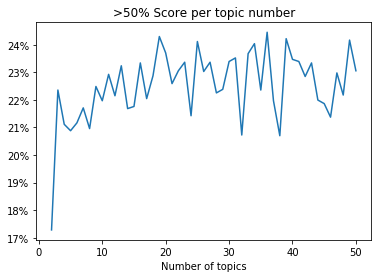

In [20]:
import matplotlib.pyplot as plt
plt.plot(score_topic)
plt.title(">50% Score per topic number")
plt.xlabel("Number of topics")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

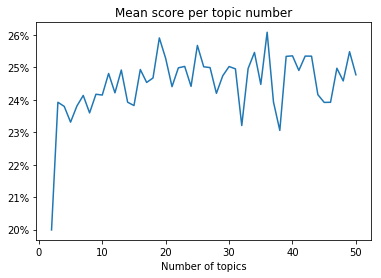

In [21]:
plt.plot(mean_topic)
plt.title("Mean score per topic number")
plt.xlabel("Number of topics")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()